In [2]:
# IMPORT
# Standard libray
import sys, os
from importlib import reload
sys.path.append("..")
import collections


# Common library
from tqdm import tqdm
import numpy as np
import scipy
from pylab import *
import scipy.interpolate

# ROOT>....
import ROOT
# Make global style changes
ROOT.gStyle.SetOptStat(0) # Disable the statistics box
ROOT.gStyle.SetTextFont(42)
# ROOT.gStyle.SetOptFit(1111)
import atlasplots as aplt
aplt.set_atlas_style()
ROOT.gStyle.SetTitleXOffset(1)
ROOT.gStyle.SetTitleYOffset(1.8)

# Custom helper functions
import muhelper.helper_basic as hp
import helper_tofpet as hptof

reload(hp)

# ROOT.gStyle.SetPalette(len(hptof.mpl_colors), hptof.mpl_colors32)
ROOT.gStyle.SetPalette(ROOT.kViridis)
# colors=[int(c) for c in hptof.mpl_colors ]
colors=hptof.mpl_colors_cls()

Applying ATLAS style settings


In [3]:
working_dir = "/mnt/sda2/tofpet_data/test_stand_init/"
filename = working_dir+"data/processed/"+  "calibration_1_coinc_hit.root"


coinc_pairs = np.loadtxt("../configurations/coinc_pairs.csv", delimiter=",", dtype=int)
coinc_pairs = {(a[0], a[1]):a[2] for a in coinc_pairs}


# Find the relation between truth position vs measured postision

In this setup, two layer are placed on top of each other but towards different direction.  

Layer 2: bar along y direction   
Layer 3: bar along x direction

Layer 3 can be used as a tag of the "true" y coordinates for coincident events in layer 2. 

In the mapping script, refractive index of 🔴1.6🔴. is used.



In [4]:
# Some constants
fiber_length = 238.0
fiber_n = 1.6
position_sipm =  -56.7
position_bar_start  = position_sipm+1.8 + 0.6
position_bar_end    = position_bar_start+100
position_mid_fiber  = position_sipm+fiber_length/2

In [5]:
tfile = ROOT.TFile.Open(filename)

tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)
branches = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
entries = Tree.GetEntries()

print("Tree name:", tree_name)
print("Branches:", branches)
print("Entries:", entries)

# Use dataframe to quickly get things into numpy
df = ROOT.RDataFrame(tree_name, filename)
# df = df.Define('dt', '0.5*(time1-time2)')

# cut_energy = "hit_nrg1>20 && hit_nrg2>20"
# data = df.Filter(cut_energy).AsNumpy()
data = df.AsNumpy()

Tree name: mapped
Branches: ['hit_x', 'hit_y', 'hit_z', 'hit_t', 'hit_x_err', 'hit_y_err', 'hit_z_err', 'hit_t_err', 'hit_ass', 'hit_det_id', 'hit_ch_id', 'hit_pair_id', 'hit_nrg1', 'hit_nrg2']
Entries: 3043476


Text(0.5, 0, 'z [cm]')

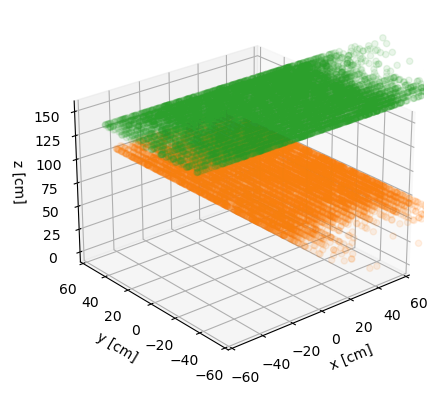

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)

n_plot=9000
for layer in range(1,5):
    mask = data["hit_ass"]==layer
    ax.scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot], data["hit_z"][mask][:n_plot], alpha=0.1, zorder=layer)

ax.view_init(elev=25, azim=230)
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)
ax.set_xlabel("x [cm]")
ax.set_ylabel("y [cm]")
ax.set_zlabel("z [cm]")

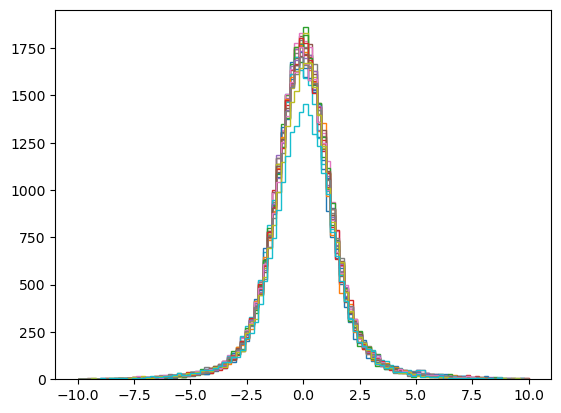

In [18]:
process_layer = 2

if process_layer==2:
    mask_top = (data["hit_ass"]==2)#&(data["hit_ch_id"]<5)
    mask_bottom_all = [(data["hit_ass"]==3)&(data["hit_ch_id"]==ch) for ch in range(1,21)]
    hit_name="hit_y"
    hit_direction=1
elif process_layer==3:
    mask_top = (data["hit_ass"]==3)#&(data["hit_ch_id"]<5)
    mask_bottom_all = [(data["hit_ass"]==2)&(data["hit_ch_id"]==ch) for ch in range(1,21)[::-1]]
    hit_name="hit_x"
    hit_direction=-1


mask_top_all =[]

t1 = np.sort(data["hit_t"][mask_top])
for ii in range(len(mask_bottom_all)):
    t2 = np.sort(data["hit_t"][mask_bottom_all[ii]])
    dt= hp.get_dt(t1,t2)
    dt = dt-np.mean(dt[abs(dt)<30])
    hist(dt, range=(-10,10), bins=100, histtype="step");
    mask_top_all.append(abs(dt)<2)

Text(0.5, 0, 'y [cm]')

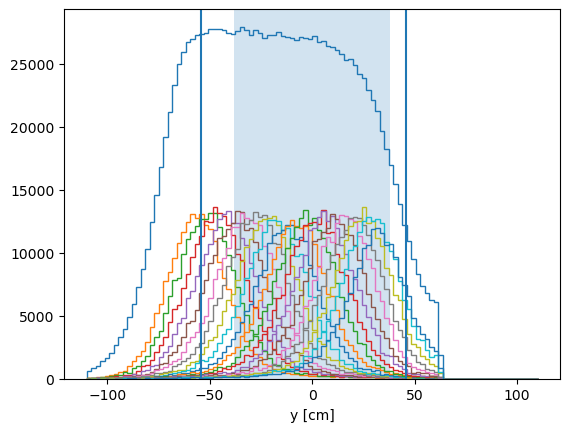

In [19]:
hist(data[hit_name][mask_top]*hit_direction, bins=100, range=[-110,110], histtype="step");
for ii in range(len(mask_bottom_all)):
    hist(data[hit_name][mask_top][mask_top_all[ii]]*hit_direction, bins=100, range=[-110,110], histtype="step", weights=10*np.ones(sum(mask_top_all[ii])));
axvline(position_bar_start)
axvline(position_bar_end)

axvspan(-38,38, alpha=0.2)
xlabel("y [cm]")

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      17.0389
NDf                       =           31
Edm                       =  5.69686e-07
NCalls                    =           76
amplitude                 =      710.313   +/-   7.34415     
mean                      =     -56.2775   +/-   0.152457    
sigma                     =      14.1806   +/-   0.197325    
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =        32.33
NDf                       =           31
Edm                       =   4.3377e-07
NCalls                    =           75
amplitude                 =      713.469   +/-   7.33862     
mean                      =     -51.8029   +/-   0.157634    
sigma                     =      14.4617   +/-   0.20688     
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      29.6347
NDf                       =           31
Edm  

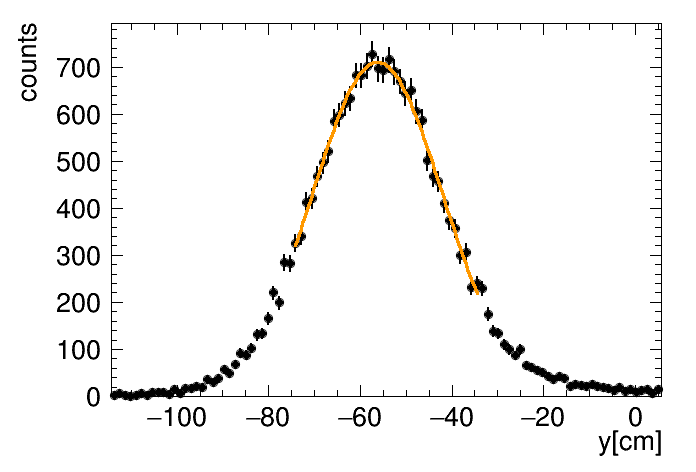

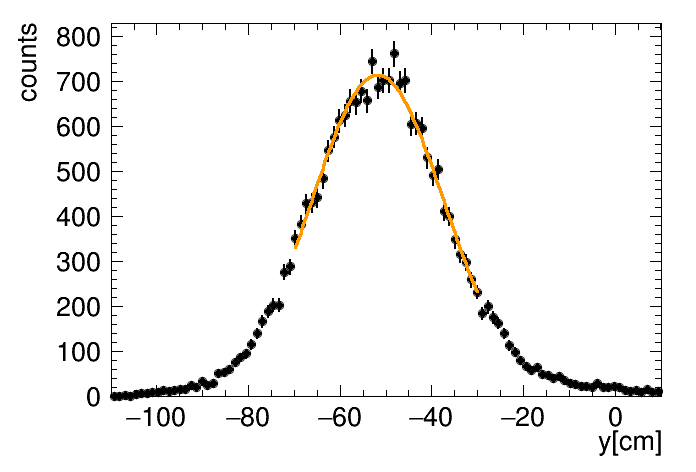

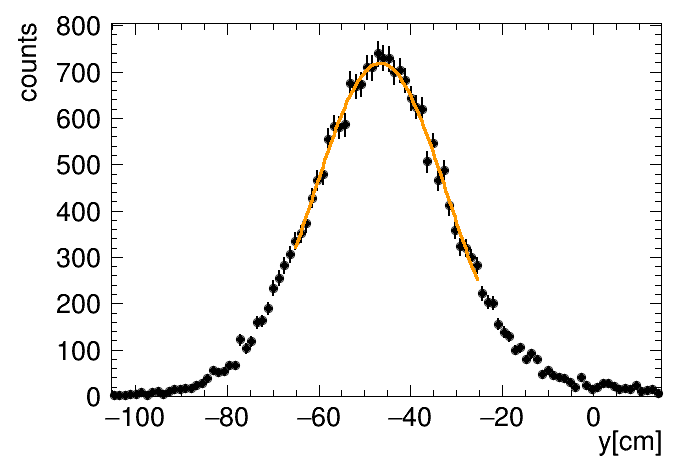

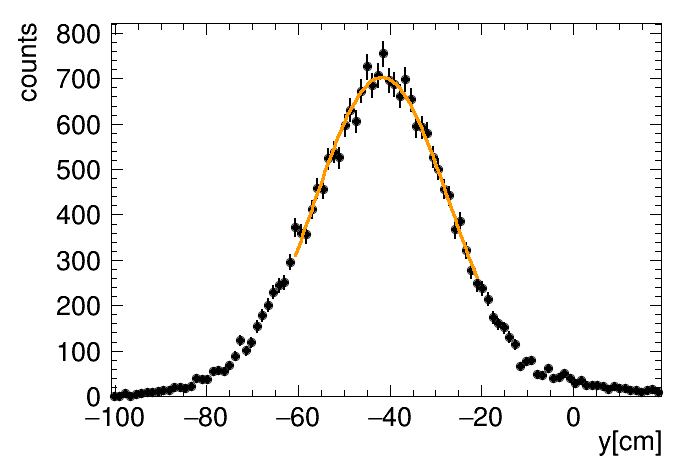

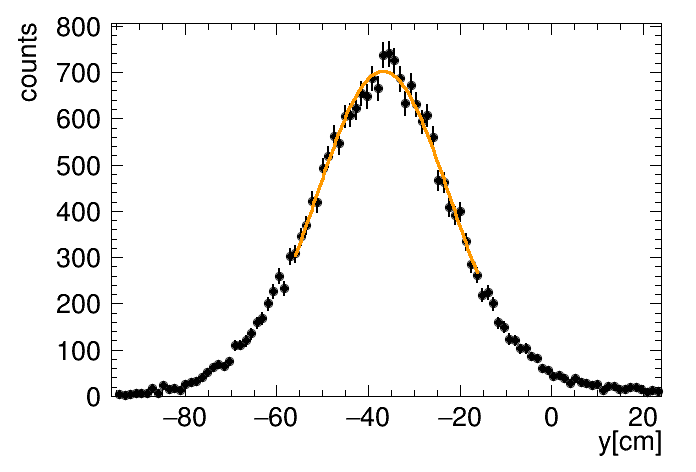

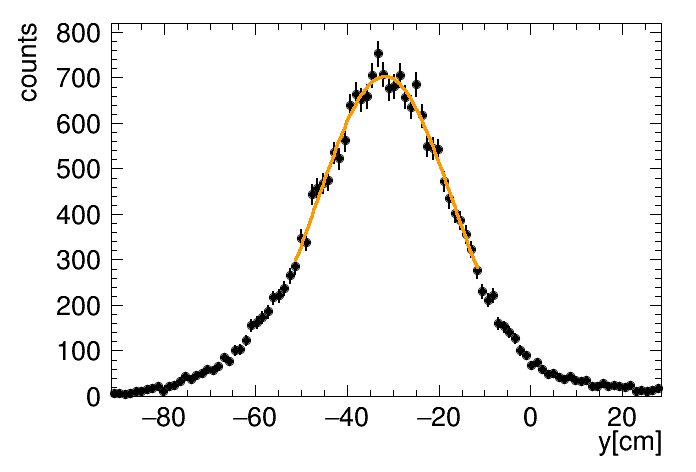

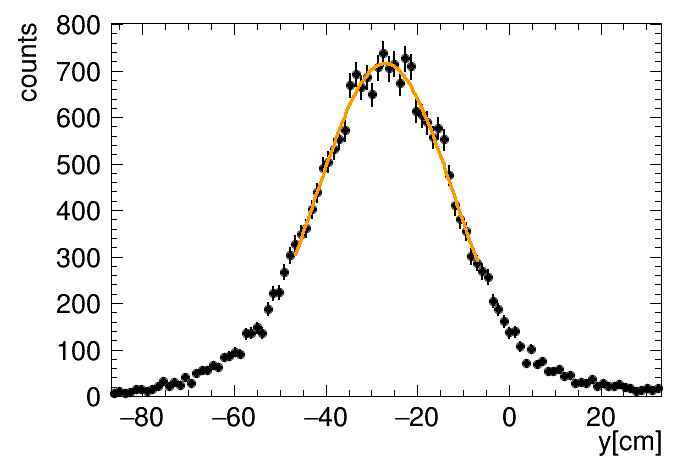

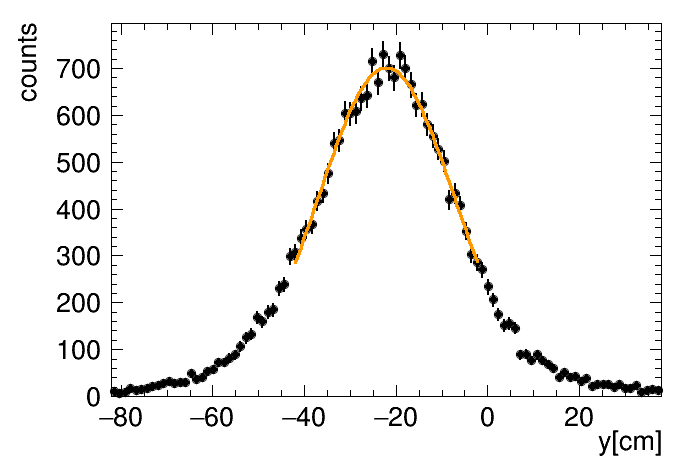

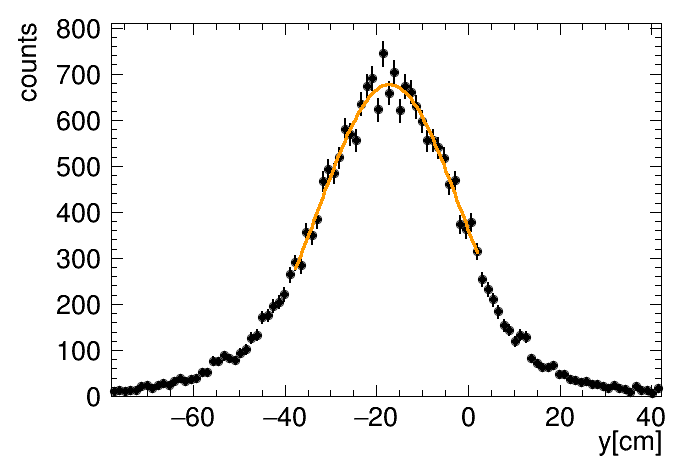

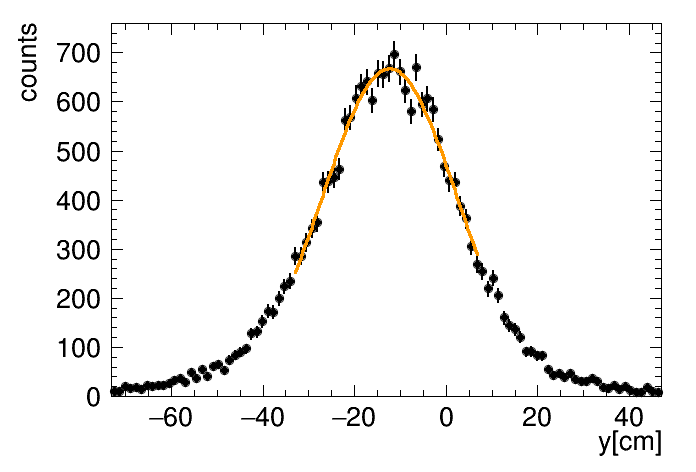

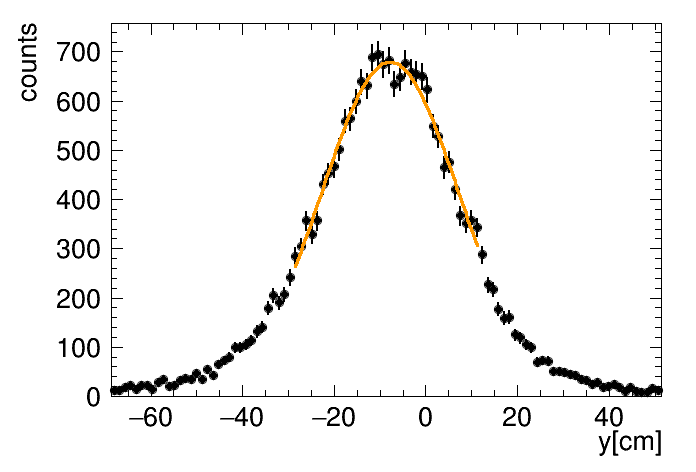

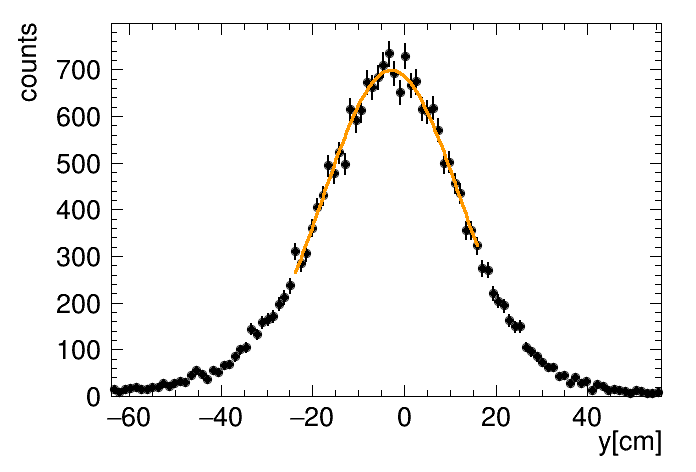

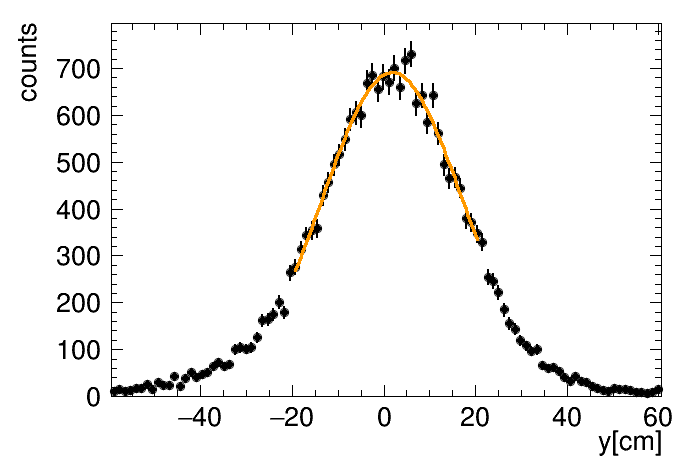

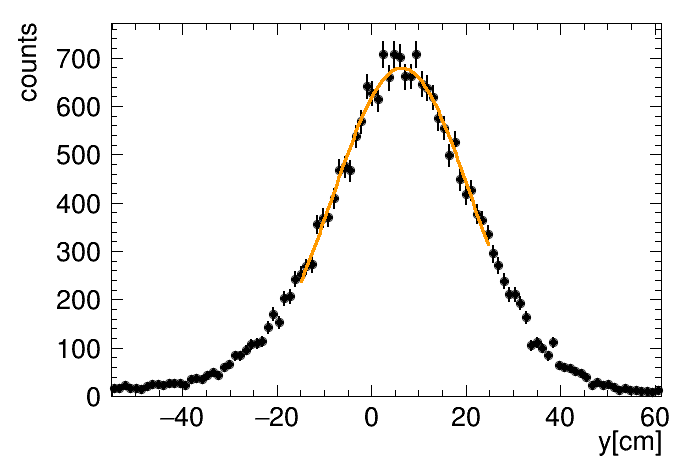

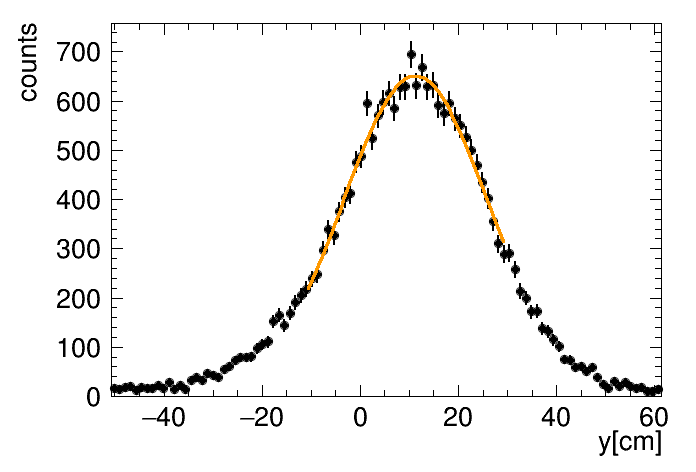

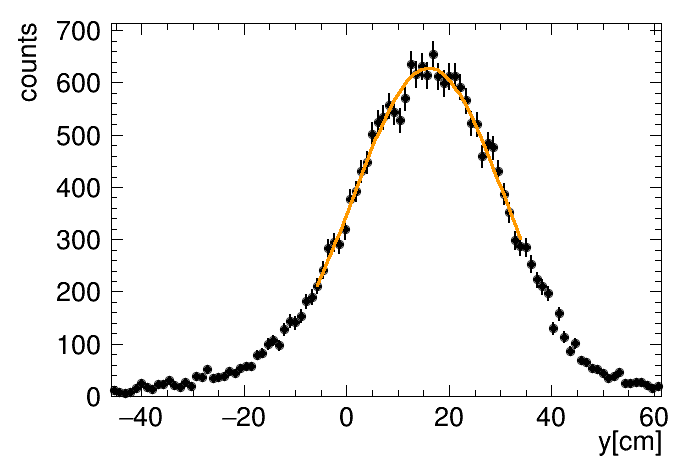

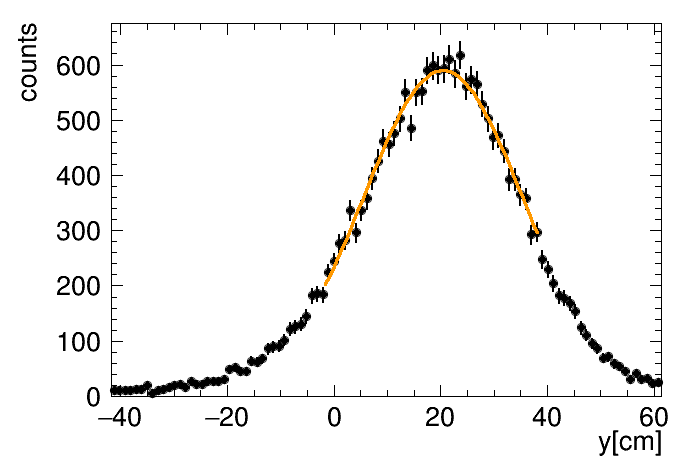

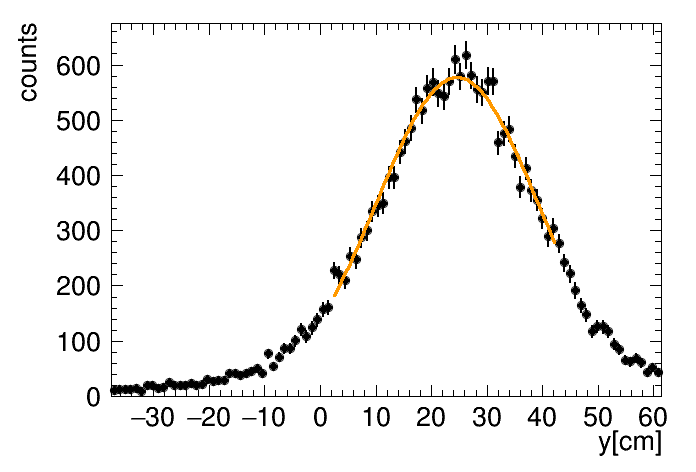

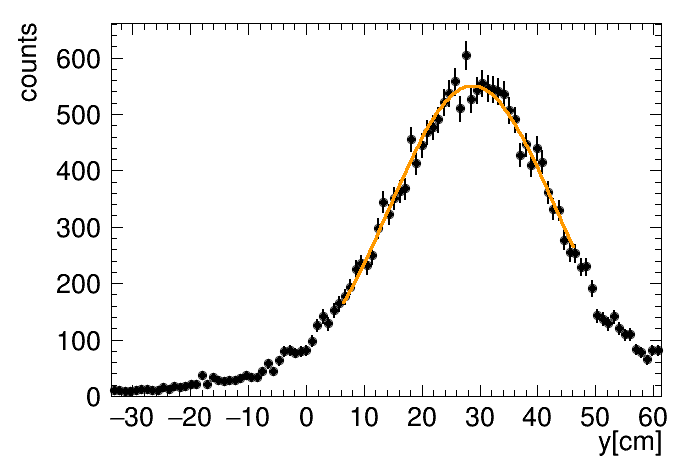

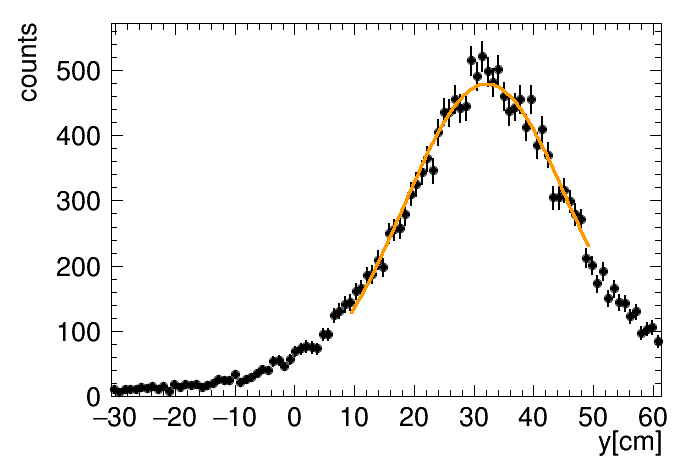

In [20]:
y_fit_results=[]
par = collections.namedtuple("par", ["amplitude", "mean", "sigma"])
c_y_fits=[] # Use the list to hold all canvas
h_y_fits=[] # Use the list to hold all canvas
for ii in range(len(mask_bottom_all)):
# for ii in [17]:
    # Canvas
    c_y_fits.append(ROOT.TCanvas()); 
    c1=c_y_fits[-1]
    c1.Draw()

    # Hist
    ys = data[hit_name][mask_top][mask_top_all[ii]]*hit_direction
    ymean = np.mean(ys)
    yrange = [ymean-60, min(ymean+60, position_mid_fiber-1)]
    yrange_fit = [ymean-20, min(ymean+20, position_mid_fiber-1)]
    h_y_fits.append(ROOT.RDF.FromNumpy({"y": ys}).Histo1D(("", ";y[cm];counts", 100, *yrange), "y"))
    h1=h_y_fits[-1]
    h1.Draw("e")

    # Fit an error function to the left edge
    f1 = ROOT.TF1('f1', '[0] * TMath::Gaus(x, [1], [2]) + [0] * TMath::Gaus(x, 62.3*2 -[1], [2])', *yrange_fit)
    f1.SetParNames("amplitude", "mean", "sigma")
    f1.SetParameters(300, ymean, 10)
    h1.Fit(f1, "RS0")
    f1.SetLineColor(int(colors[1]))
    f1.Draw("SAME")


    # Save result
    y_fit_results.append(par(f1.GetParameter(0), f1.GetParameter(1), f1.GetParameter(2)))

In [21]:
y_meas = [a.mean for a  in y_fit_results]
y_true = np.arange(20)*4+-38

fig, ax = aplt.subplots(1, 1, name = "s5")
g1 = ax.graph(y_true, y_meas, label="Data", labelfmt="EP")
# Fit the graph; store graphics func but do not draw
g1.Fit("pol1", "0S")

func = g1.GetFunction("pol1")
func.SetRange(*ax.get_xlim())
func.SetNpx(1000)
ax.plot(func, linecolor=ROOT.kRed+1, expand=False, label="Fit", labelfmt="L")

# Set axis titles
ax.set_xlabel("Truth [cm]")
ax.set_ylabel("Measured [cm]")

# Add legend
ax.legend(loc=(0.65, 0.8, 0.95, 0.92))

# Save the plot as a PDF
# fig.savefig("numpy_graph.pdf")

****************************************
Minimizer is Linear / Migrad
Chi2                      =      10.4978
NDf                       =           18
p0                        =     -10.6701   +/-   0.170765    
p1                        =      1.18318   +/-   0.0074036   


Warning in <TCanvas::Constructor>: Deleting canvas with same name: s5


Corrected refractive index 1.8930957363987782
Corrected velocity of light 15.835966149830767 [cm/ns]


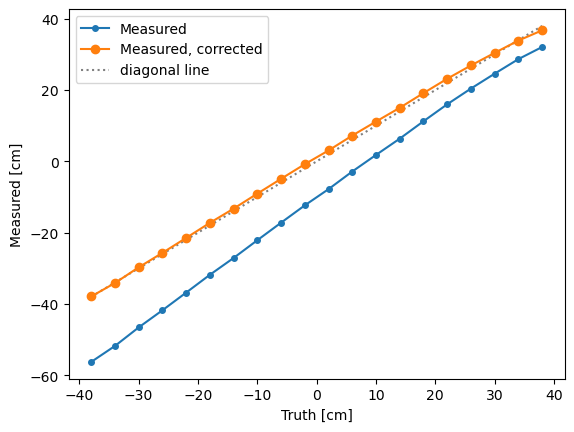

In [22]:
refractive_index_corr = fiber_n*func.GetParameter(1)
speed_of_light_corr = 29.979/refractive_index_corr
print("Corrected refractive index", refractive_index_corr)
print("Corrected velocity of light", speed_of_light_corr, "[cm/ns]")

y_meas_corrected = [position_mid_fiber - (position_mid_fiber-x)/func.GetParameter(1) for x in y_meas]
plot(y_true,y_meas, marker="o", markersize=4, label="Measured")
plot(y_true,y_meas_corrected, marker="o", label="Measured, corrected")
plot(y_true, y_true, color="grey", zorder=0, linestyle=":", label="diagonal line")
xlabel("Truth [cm]")
ylabel("Measured [cm]")
legend()

In [8]:
# hist(data["hit_x"][mask][:n_plot], bins=100, range=[-70,70], histtype="step");
# axvline(-46)
# axvline(100-46)

In [9]:
# layer=3
# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==77)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])
        
# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==66)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])

# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==125)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])

# mask = (data["hit_ass"]==layer)&(data["hit_det_id"]==123)
# scatter(data["hit_x"][mask][:n_plot], data["hit_y"][mask][:n_plot])